## LSTM MODEL WITH UNEMPLOYMENT RATE: 1ST ATTEMPT

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import sys
import copy
import optuna

In [2]:
# Load Data (as csv) for LSTM model

#Reshape the data to create two features 
def get_unrate_ts():
    lstm_df = pd.read_csv('UR_data.csv')
    #transform the dataset to work with scaler
    ts = lstm_df['UNRATE'].astype(int).values.reshape(-1,1)
    return ts

#print the shape of the dataset
ts = get_unrate_ts()
print(f"Shape of ts: {ts.shape}")

Shape of ts: (914, 1)


In [3]:
#Include dropout in the LSTM layer: 
from torch.nn import Dropout

class LSTM(nn.Module):

    def __init__(self,
              hidden_size,
              in_size=1,
              out_size=1,
              dropout_p=0.431  # Dropout probability (optional) set with best
              ):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=in_size,
            hidden_size=hidden_size,
            batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)

    # Add dropout layer (optional)
        if dropout_p > 0:
            self.dropout = nn.Dropout(p=dropout_p)
        else:
            self.dropout = None  # No dropout if p is not set

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1]

    # Apply dropout if it exists
        if self.dropout is not None:
            last_hidden_states = self.dropout(last_hidden_states)  # Apply dropout

        out = self.fc(last_hidden_states)
        
        return out, h

In [4]:
#length of sliding window
features = 60 #number of data points (steps) at a time. its the 'lookback period'

#length of test dataset
test_ts_len = 150 #copy RNN model

#size of LSTM hidden state
lstm_hidden_size = 48 #increased from 24 initially which only predicted 100 epochs

#Optimizer learning rate
learning_rate = 0.01 #lowered learning rate from 0.02 to increase precision
training_epochs = 250

In [5]:
#Training datasets df
def get_training_datasets(ts, features, test_len):
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len],\
                                       Y[0:-test_len],\
                                       X[-test_len:],\
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train).float()
    y_train = torch.tensor(data = Y_train).float()

    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()

    x_test = torch.tensor(data = X_test).float()
    y_test = torch.tensor(data = Y_test).float()

    return x_train, x_val, x_test,\
           y_train.squeeze(1), y_val.squeeze(1), y_test.squeeze(1)

In [6]:
#Sliding window df
def sliding_window(ts, features):
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append(ts[i - 1])  # Directly append the target value

    return X, Y

In [7]:
#Prepare datasets for training
ts = get_unrate_ts()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

#Initializing the model
model = LSTM(hidden_size = lstm_hidden_size)
model.train()

/var/folders/pr/r9s7fv8d3hl7zl078q3rzs_00000gn/T/ipykernel_24367/2276076278.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x_train = torch.tensor(data = X_train).float()


LSTM(
  (lstm): LSTM(1, 48, batch_first=True)
  (fc): Linear(in_features=48, out_features=1, bias=True)
  (dropout): Dropout(p=0.431, inplace=False)
)

In [8]:
#Train LSTM model
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()
best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):
    
    prediction, _ = model(x_train)
    loss = mse_loss(prediction, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()
        
    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}', f'val: - {round(val_loss.item(), 4)}')

epoch 0: train - 0.0857 val: - 0.0968


/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([640])) that is different to the input size (torch.Size([640, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ryak/anaconda3/envs/dev/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 10: train - 0.0182 val: - 0.0548
epoch 20: train - 0.017 val: - 0.057
epoch 30: train - 0.0168 val: - 0.0492
epoch 40: train - 0.0166 val: - 0.0508
epoch 50: train - 0.0164 val: - 0.052
epoch 60: train - 0.0163 val: - 0.0502
epoch 70: train - 0.0163 val: - 0.0512
epoch 80: train - 0.0162 val: - 0.051
epoch 90: train - 0.0162 val: - 0.0509
epoch 100: train - 0.0161 val: - 0.0513
epoch 110: train - 0.0161 val: - 0.0524
epoch 120: train - 0.016 val: - 0.0516
epoch 130: train - 0.016 val: - 0.051
epoch 140: train - 0.016 val: - 0.0518
epoch 150: train - 0.016 val: - 0.0513
epoch 160: train - 0.016 val: - 0.0509
epoch 170: train - 0.0159 val: - 0.0511
epoch 180: train - 0.0159 val: - 0.0507
epoch 190: train - 0.0159 val: - 0.0515
epoch 200: train - 0.0159 val: - 0.0509
epoch 210: train - 0.0159 val: - 0.0509
epoch 220: train - 0.0159 val: - 0.0505
epoch 230: train - 0.0159 val: - 0.0511
epoch 240: train - 0.0159 val: - 0.0512


In [9]:
#Evaluate LSTM model
best_model.eval()

with torch.no_grad():
    
    _, h_list = best_model(x_val)
    
    #warm hidden cell and cell state
    h = tuple([(h[-1, -1, :]).unsqueeze(-2).unsqueeze(-2) for h in h_list])
    
    lstm_predicted = []
    
    for test_seq in x_test.tolist():
        x = torch.tensor(data =[test_seq])
        
        #passing hidden state and cell through each iteration
        y, h = best_model(x, h)
        unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
        
        lstm_predicted.append(unscaled) 

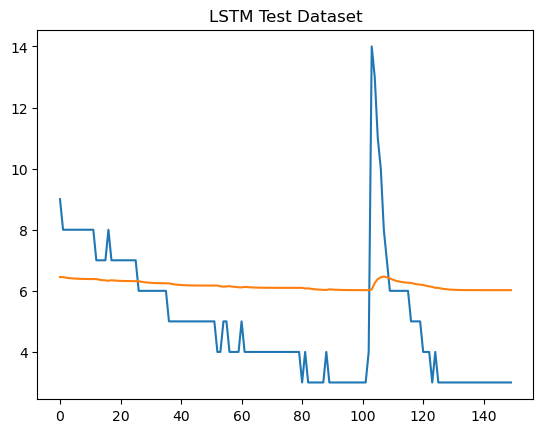

In [10]:
#Performance on the LSTM test dataset
real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.title("LSTM Test Dataset")
plt.plot(real, label = 'real')
plt.plot(lstm_predicted, label = 'lstm_predicted')
plt.legend
plt.show()

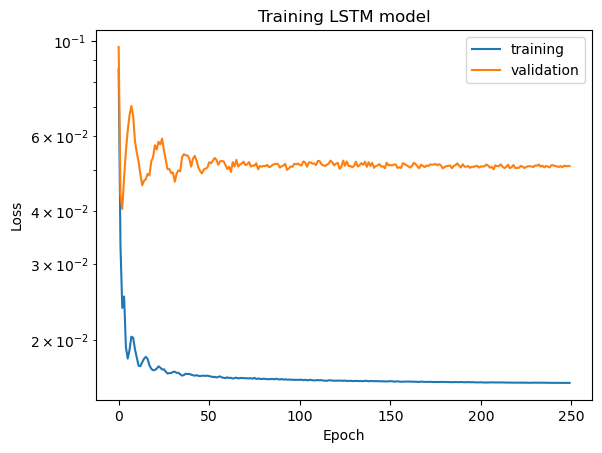

In [11]:
#Training progress with LSTM Model
plt.title('Training LSTM model')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
# Attempt at calculating the best model MSE
from sklearn.metrics import mean_squared_error

best_model.eval()
test_prediction, _ = best_model(x_test)

#Convert tensors to numpy arrays
y_test_np = y_test.detach().numpy()
test_prediction_np = test_prediction.detach().numpy()

# Calculating the accuracy score
#threshold = 0.1
mse = mean_squared_error(y_test_np, test_prediction_np)

print(f"RNN MSE: {mse}")

RNN MSE: 0.03654508665204048


In [13]:
#Attempt at calculating the best model R-squared score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_np, test_prediction_np)

print(f"RNN R-Squared: {r2}")

RNN R-Squared: -0.25781920611139864


In [14]:
print(f"lstm_predicted {lstm_predicted}")

lstm_predicted [6.450361967086792, 6.450361967086792, 6.431076526641846, 6.417276382446289, 6.407422304153442, 6.400332689285278, 6.395247220993042, 6.391627311706543, 6.38907527923584, 6.387296438217163, 6.3860697746276855, 6.385233640670776, 6.384670734405518, 6.364461898803711, 6.3499815464019775, 6.339656114578247, 6.332244634628296, 6.346873760223389, 6.337468147277832, 6.3307390213012695, 6.326035499572754, 6.322695255279541, 6.320319175720215, 6.318639039993286, 6.317460298538208, 6.316640615463257, 6.316077709197998, 6.295323133468628, 6.2804114818573, 6.26977276802063, 6.262141704559326, 6.256692171096802, 6.252832651138306, 6.250127553939819, 6.248252868652344, 6.2469682693481445, 6.246099233627319, 6.224621534347534, 6.209172010421753, 6.198162078857422, 6.190279960632324, 6.184663772583008, 6.180697679519653, 6.177926063537598, 6.17601203918457, 6.174704551696777, 6.173823356628418, 6.1732354164123535, 6.172847747802734, 6.172595977783203, 6.172434329986572, 6.1723313331604

## INITIAL CONCLUSION: THE FIRST ATTEMPT WITH LSTM WAS SUCCESSFUL AND I LEARNED THAT INCREASING THE NUMBER OF HIDDEN SIZE FROM 24 to 48 literally improved the predictions. I will now run an optuna study with a big range of predictions. 

In [15]:
#Optuna trial:
def objective(trial, LSTM, get_unrate_ts, get_training_datasets, sliding_window):
    
    #Fixed Parameters in LSTM model
    #features = 12 #feature is the # preceding steps used to predict next step
    training_epochs = 300
    
    # Suggest lstm_hidden size, learning rate, test_ts_len
    lstm_hidden_size = trial.suggest_int("lstm_hidden_size", 24, 68)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.05)
    test_ts_len = trial.suggest_int("test_ts_len", 100, 200)
    dropout_p = trial.suggest_float("dropout_p", 0.10, 0.50)
    features = trial.suggest_int("features", 2, 24)
    
    #Prepare datasets for training
    ts = get_unrate_ts()
    scaler = MinMaxScaler()
    scaled_ts = scaler.fit_transform(ts)
    x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

    #Initializing the model
    model = LSTM(hidden_size = lstm_hidden_size)
    model.train()
    
    #Train LSTM model
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    mse_loss = torch.nn.MSELoss()
    best_model = None
    min_val_loss = sys.maxsize

    training_loss = []
    validation_loss = []

    for t in range(training_epochs):
    
        prediction, _ = model(x_train)
        loss = mse_loss(prediction.squeeze(1), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        val_prediction, _ = model(x_val)
        val_loss = mse_loss(val_prediction.squeeze(1), y_val)
        training_loss.append(loss.item())
        validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()
    
    return min_val_loss #Return min validation loss for comparison

# Optuna study
study = optuna.create_study(
    storage ="sqlite:///LSTM.sqlite3",
    study_name = "LSTM_13")

# Optimize Study
study.optimize(lambda trial: objective(trial, LSTM, get_unrate_ts, get_training_datasets, sliding_window), n_trials=100)

#Access best params and best trial
best_params = study.best_params
best_trial = study.best_trial

[I 2024-04-13 15:42:01,931] A new study created in RDB with name: LSTM_13
[I 2024-04-13 15:42:04,369] Trial 0 finished with value: 0.0008830367587506771 and parameters: {'lstm_hidden_size': 45, 'learning_rate': 0.017611162639831746, 'test_ts_len': 186, 'dropout_p': 0.27586461973635545, 'features': 7}. Best is trial 0 with value: 0.0008830367587506771.
[I 2024-04-13 15:42:07,781] Trial 1 finished with value: 0.001405981252901256 and parameters: {'lstm_hidden_size': 54, 'learning_rate': 0.04147138688055005, 'test_ts_len': 178, 'dropout_p': 0.4998935437798523, 'features': 8}. Best is trial 0 with value: 0.0008830367587506771.
[I 2024-04-13 15:42:13,566] Trial 2 finished with value: 0.0014158147387206554 and parameters: {'lstm_hidden_size': 40, 'learning_rate': 0.015941560373917533, 'test_ts_len': 178, 'dropout_p': 0.3216693134992272, 'features': 20}. Best is trial 0 with value: 0.0008830367587506771.
[I 2024-04-13 15:42:14,940] Trial 3 finished with value: 0.0009145792573690414 and parame

In [25]:
print(best_params)

{'lstm_hidden_size': 67, 'learning_rate': 0.033620802198976944, 'test_ts_len': 195, 'dropout_p': 0.4528453435259909, 'features': 6}


In [26]:
print(best_trial)

FrozenTrial(number=82, state=TrialState.COMPLETE, values=[0.0006555138388648629], datetime_start=datetime.datetime(2024, 4, 13, 15, 45, 48, 571742), datetime_complete=datetime.datetime(2024, 4, 13, 15, 45, 51, 454008), params={'lstm_hidden_size': 67, 'learning_rate': 0.033620802198976944, 'test_ts_len': 195, 'dropout_p': 0.4528453435259909, 'features': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lstm_hidden_size': IntDistribution(high=68, log=False, low=24, step=1), 'learning_rate': FloatDistribution(high=0.05, log=False, low=0.001, step=None), 'test_ts_len': IntDistribution(high=200, log=False, low=100, step=1), 'dropout_p': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'features': IntDistribution(high=24, log=False, low=2, step=1)}, trial_id=730, value=None)


## 3rd STEP: Take BEST PARAMS for LSTM model and create FORECASTS for UNRATE

In [ ]:
#Reset the dropout rate:  
from torch.nn import Dropout

class LSTM(nn.Module):

    def __init__(self,
              hidden_size,
              in_size=1,
              out_size=1,
              dropout_p=0.45  # Dropout probability set with best param
              ):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=in_size,
            hidden_size=hidden_size,
            batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)

    # Add dropout layer (optional)
        if dropout_p > 0:
            self.dropout = nn.Dropout(p=dropout_p)
        else:
            self.dropout = None  # No dropout if p is not set

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1]

    # Apply dropout if it exists
        if self.dropout is not None:
            last_hidden_states = self.dropout(last_hidden_states)  # Apply dropout

        out = self.fc(last_hidden_states)
        
        return out, h

In [27]:
#Train LSTM model with best params
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()
best_model = None
min_val_loss = sys.maxsize

#Best_Parameters:
features = 6
training_epochs = 500
lstm_hidden_size = 64
learning_rate = 0.03
test_ts_len = 195

#Prepare datasets for training
ts = get_unrate_ts()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

#Initializing the model
model = LSTM(hidden_size = lstm_hidden_size)
model.train()

training_loss = []
validation_loss = []

for t in range(training_epochs):

    prediction, _ = model(x_train)
    loss = mse_loss(prediction.squeeze(1), y_train) #Add squeeze to remove dimension
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction.squeeze(1), y_val)
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()
        
    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}', f'val: - {round(val_loss.item(), 4)}')

epoch 0: train - 0.0924 val: - 0.0564
epoch 10: train - 0.0927 val: - 0.0579
epoch 20: train - 0.0922 val: - 0.0592
epoch 30: train - 0.0927 val: - 0.0589
epoch 40: train - 0.093 val: - 0.0603
epoch 50: train - 0.0929 val: - 0.0583
epoch 60: train - 0.0916 val: - 0.0598
epoch 70: train - 0.0936 val: - 0.0572
epoch 80: train - 0.0931 val: - 0.0602
epoch 90: train - 0.0923 val: - 0.0589
epoch 100: train - 0.0938 val: - 0.0592
epoch 110: train - 0.0925 val: - 0.0597
epoch 120: train - 0.0923 val: - 0.0565
epoch 130: train - 0.0929 val: - 0.0592
epoch 140: train - 0.094 val: - 0.0574
epoch 150: train - 0.0917 val: - 0.0605
epoch 160: train - 0.0929 val: - 0.058
epoch 170: train - 0.0931 val: - 0.058
epoch 180: train - 0.0943 val: - 0.0566
epoch 190: train - 0.093 val: - 0.0617
epoch 200: train - 0.0924 val: - 0.0588
epoch 210: train - 0.0932 val: - 0.0608
epoch 220: train - 0.0928 val: - 0.0581
epoch 230: train - 0.0937 val: - 0.0583
epoch 240: train - 0.0932 val: - 0.0609
epoch 250: train

In [28]:
#Evaluate LSTM model
best_model.eval()

with torch.no_grad():
    
    _, h_list = best_model(x_val)
    
    #warm hidden cell and cell state
    h = tuple([(h[-1, -1, :]).unsqueeze(-2).unsqueeze(-2) for h in h_list])
    
    lstm_predicted = []
    
    for test_seq in x_test.tolist():
        x = torch.tensor(data =[test_seq])
        
        #passing hidden state and cell through each iteration
        y, h = best_model(x, h)
        unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
        
        lstm_predicted.append(unscaled)

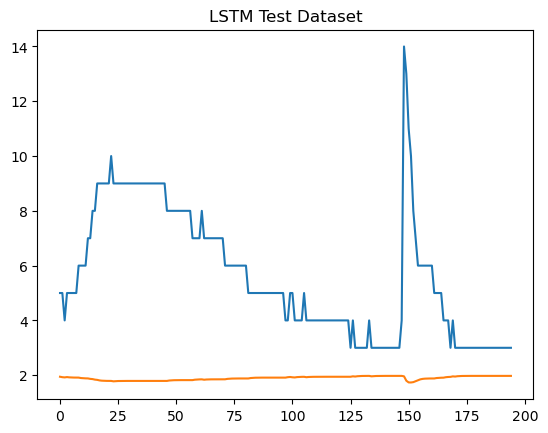

In [29]:
#Performance on the LSTM test dataset
real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.title("LSTM Test Dataset")
plt.plot(real, label = 'real')
plt.plot(lstm_predicted, label = 'lstm_predicted')
plt.legend
plt.show()

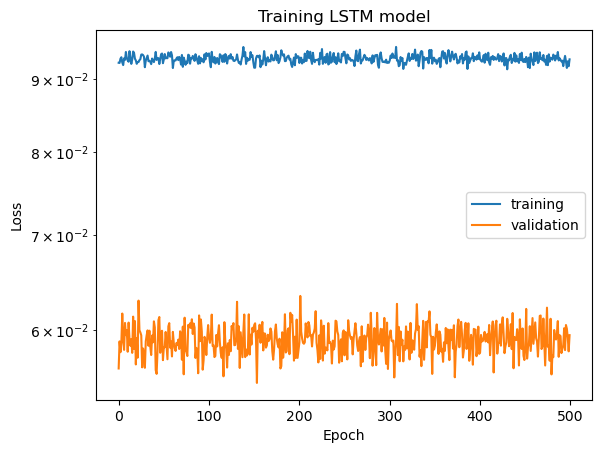

In [30]:
#Training progress with LSTM Model
plt.title('Training LSTM model')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [31]:
print(lstm_predicted)

[1.9437762945890427, 1.9273970276117325, 1.919577270746231, 1.9311445206403732, 1.921213373541832, 1.9162825793027878, 1.9137729704380035, 1.9127856492996216, 1.9122587740421295, 1.8961823731660843, 1.8884771019220352, 1.8845332711935043, 1.8824507594108582, 1.8660554885864258, 1.8578779697418213, 1.8388957530260086, 1.8294165134429932, 1.8096480518579483, 1.7997836023569107, 1.7950448989868164, 1.7925768196582794, 1.7915546298027039, 1.791013851761818, 1.7763427942991257, 1.783763349056244, 1.787355676293373, 1.7891088128089905, 1.7900011837482452, 1.7904718667268753, 1.7910018265247345, 1.7910074591636658, 1.791007548570633, 1.791007548570633, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.7910075932741165, 1.8057767748832703, 1.8131143599748611, 1.816838338971138, 1.81878

In [32]:
# Attempt at calculating the best model MSE
from sklearn.metrics import mean_squared_error

best_model.eval()
test_prediction, _ = best_model(x_test)

#Convert tensors to numpy arrays
y_test_np = y_test.detach().numpy()
test_prediction_np = test_prediction.detach().numpy()

# Calculating the accuracy score
#threshold = 0.1
mse = mean_squared_error(y_test_np, test_prediction_np)

print(f"RNN MSE: {mse}")

RNN MSE: 0.13516941666603088


In [33]:
#Attempt at calculating the best model R-squared score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_np, test_prediction_np)

print(f"RNN R-Squared: {r2}")

RNN R-Squared: -2.595395292617774


## Try GRU WITH DROPOUT AND OPTUNA TRIAL

In [37]:
#Create GRU model with dropout built in
class GRU(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1,
                 dropout_p=0.2): #set in Optuna trial
        
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

        # Add dropout layer (optional)
        if dropout_p > 0:
            self.dropout = nn.Dropout(p=dropout_p)
        else:
            self.dropout = None  # No dropout if p is not set
        
    def forward(self, x, h = None):
        out, _ = self.gru(x, h)
        last_hidden_states = out[:, -1]
        
        # Apply dropout if it exists
        if self.dropout is not None:
            last_hidden_states = self.dropout(last_hidden_states)  # Apply dropout
        
        out = self.fc(last_hidden_states)
        
        return out, last_hidden_states

In [38]:
#Optuna trial for GRU model
def objective(trial, GRU, get_unrate_ts, get_training_datasets, sliding_window):
    
    #Fixed Parameters in GRU model
    training_epochs = 300
    
    # Suggest lstm_hidden size, learning rate, test_ts_len, eatures
    gru_hidden_size = trial.suggest_int("lstm_hidden_size", 24, 68)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.05)
    test_ts_len = trial.suggest_int("test_ts_len", 100, 200)
    dropout_p = trial.suggest_float("dropout_p", 0.10, 0.50)
    features = trial.suggest_int("features", 2, 24)
    
    #Prepare datasets for training
    ts = get_unrate_ts()
    scaler = MinMaxScaler()
    scaled_ts = scaler.fit_transform(ts)
    x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

    #Initializing the model
    model = GRU(hidden_size = gru_hidden_size)
    model.train()
    
    #Train LSTM model
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    mse_loss = torch.nn.MSELoss()
    best_model = None
    min_val_loss = sys.maxsize

    training_loss = []
    validation_loss = []

    for t in range(training_epochs):
    
        prediction, _ = model(x_train)
        loss = mse_loss(prediction.squeeze(1), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        val_prediction, _ = model(x_val)
        val_loss = mse_loss(val_prediction.squeeze(1), y_val)
        training_loss.append(loss.item())
        validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()
    
    return min_val_loss #Return min validation loss for comparison

# Optuna study
study = optuna.create_study(
    storage ="sqlite:///GRU.sqlite3",
    study_name = "GRU_03")

# Optimize Study
study.optimize(lambda trial: objective(trial, GRU, get_unrate_ts, get_training_datasets, sliding_window), n_trials=100)

#Access best params and best trial
best_params = study.best_params
best_trial = study.best_trial

[I 2024-04-13 15:59:16,186] A new study created in RDB with name: GRU_03
[I 2024-04-13 15:59:17,666] Trial 0 finished with value: 0.001100523630157113 and parameters: {'lstm_hidden_size': 32, 'learning_rate': 0.028235168925528593, 'test_ts_len': 150, 'dropout_p': 0.357439266318321, 'features': 8}. Best is trial 0 with value: 0.001100523630157113.
[I 2024-04-13 15:59:22,683] Trial 1 finished with value: 0.0015974311390891671 and parameters: {'lstm_hidden_size': 48, 'learning_rate': 0.005623447379256393, 'test_ts_len': 169, 'dropout_p': 0.3741781330159603, 'features': 19}. Best is trial 0 with value: 0.001100523630157113.
[I 2024-04-13 15:59:28,017] Trial 2 finished with value: 0.0006773675559088588 and parameters: {'lstm_hidden_size': 44, 'learning_rate': 0.04949174522278088, 'test_ts_len': 197, 'dropout_p': 0.33511118538058665, 'features': 20}. Best is trial 2 with value: 0.0006773675559088588.
[I 2024-04-13 15:59:33,930] Trial 3 finished with value: 0.0009541339240968227 and parameter

In [39]:
print(best_params)

{'lstm_hidden_size': 62, 'learning_rate': 0.049718400912168004, 'test_ts_len': 195, 'dropout_p': 0.23923240208223356, 'features': 3}


In [40]:
#Set best dropout rate for GRU model
class GRU(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1,
                 dropout_p=0.24): #set in Optuna trial
        
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

        # Add dropout layer (optional)
        if dropout_p > 0:
            self.dropout = nn.Dropout(p=dropout_p)
        else:
            self.dropout = None  # No dropout if p is not set
        
    def forward(self, x, h = None):
        out, _ = self.gru(x, h)
        last_hidden_states = out[:, -1]
        
        # Apply dropout if it exists
        if self.dropout is not None:
            last_hidden_states = self.dropout(last_hidden_states)  # Apply dropout
        
        out = self.fc(last_hidden_states)
        
        return out, last_hidden_states

In [41]:
#Run the best GRU model

#Best Parameters
training_epochs = 300
gru_hidden_size = 62
learning_rate = 0.05
test_ts_len = 195
dropout_p = 0.24
features = 3
    
#Prepare datasets for training
ts = get_unrate_ts()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

#Initializing the model
model = GRU(hidden_size = gru_hidden_size)
model.train()
    
#Train LSTM model
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()
best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):
    
    prediction, _ = model(x_train)
    loss = mse_loss(prediction.squeeze(1), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction.squeeze(1), y_val)
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}', f'val: - {round(val_loss.item(), 4)}')    

epoch 0: train - 0.0571 val: - 0.4637
epoch 10: train - 0.0274 val: - 0.0253
epoch 20: train - 0.0038 val: - 0.0063
epoch 30: train - 0.003 val: - 0.0013
epoch 40: train - 0.0019 val: - 0.0017
epoch 50: train - 0.0017 val: - 0.0009
epoch 60: train - 0.0017 val: - 0.0011
epoch 70: train - 0.0015 val: - 0.0008
epoch 80: train - 0.0014 val: - 0.0008
epoch 90: train - 0.0014 val: - 0.0008
epoch 100: train - 0.0013 val: - 0.0008
epoch 110: train - 0.0014 val: - 0.0009
epoch 120: train - 0.0013 val: - 0.0007
epoch 130: train - 0.0013 val: - 0.0007
epoch 140: train - 0.0013 val: - 0.0008
epoch 150: train - 0.0013 val: - 0.0007
epoch 160: train - 0.0013 val: - 0.0008
epoch 170: train - 0.0012 val: - 0.0008
epoch 180: train - 0.0012 val: - 0.0008
epoch 190: train - 0.0012 val: - 0.0007
epoch 200: train - 0.0013 val: - 0.0008
epoch 210: train - 0.0012 val: - 0.0007
epoch 220: train - 0.0012 val: - 0.0007
epoch 230: train - 0.0012 val: - 0.0007
epoch 240: train - 0.0013 val: - 0.0007
epoch 250: t

In [43]:
#Evaluate the GRU model

best_model.eval()
_, h_list = best_model(x_val) # -, is used to disgard the output predictions because they aren't needed here.

#Warm hidden state
h = (h_list[-1, :]).unsqueeze(-2) # [-1,:] takes the last hidden state. Unsqueeze(-2) adds 2d diminsion to match output.

gru_predicted = []

for test_seq in x_test.tolist():
    x = torch.Tensor(data =[test_seq]) #Converst the test_seq to a PyTorch tensor
    
    #Passing the hidden state through each iteration
    y, h = best_model(x, h.unsqueeze(-2)) #Passes x and h (warm hidden state) through the model.
    
    #returns the predicted y back to its original scale and reshapes output data to 2D array extracted as a single value
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    
    gru_predicted.append(unscaled)

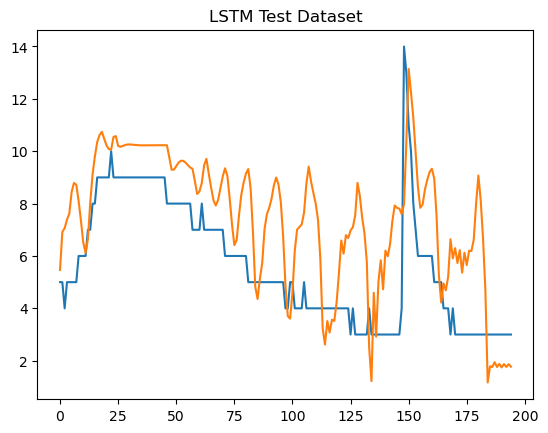

In [44]:
#Performance on the LSTM test dataset
real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.title("GRU Test Dataset")
plt.plot(real, label = 'real')
plt.plot(gru_predicted, label = 'GRU_predicted')
plt.legend
plt.show()

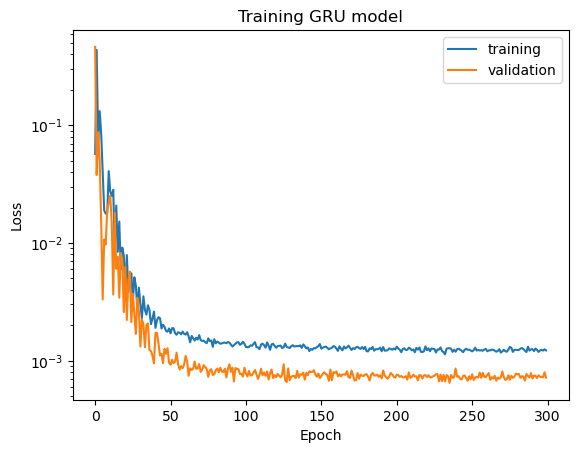

In [45]:
#Training progress with LSTM Model
plt.title('Training GRU model')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [48]:
# Attempt at calculating the best model MSE
from sklearn.metrics import mean_squared_error

best_model.eval()
test_prediction, _ = best_model(x_test)

#Convert tensors to numpy arrays
y_test_np = y_test.detach().numpy()
test_prediction_np = test_prediction.detach().numpy()

# Calculating the accuracy score
#threshold = 0.1
mse = mean_squared_error(y_test_np, test_prediction_np)

print(f"GRU MSE: {mse}")

GRU MSE: 0.0058531248942017555


In [49]:
#Attempt at calculating the best model R-squared score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_np, test_prediction_np)

print(f"GRU R-Squared: {r2}")

GRU R-Squared: 0.8443116767186567


In [50]:
print(f"GRU predictions: {gru_predicted}")

GRU predictions: [5.4675962924957275, 6.914724230766296, 7.063634395599365, 7.391482949256897, 7.617099285125732, 8.445336818695068, 8.78835916519165, 8.72104787826538, 8.102019786834717, 7.352080225944519, 6.515555381774902, 6.113310933113098, 6.649067163467407, 8.026206970214844, 9.10960054397583, 9.802056074142456, 10.352614879608154, 10.614274024963379, 10.742148876190186, 10.477530002593994, 10.21826696395874, 10.081238269805908, 10.055974006652832, 10.543309211730957, 10.578884601593018, 10.204483985900879, 10.167483806610107, 10.202745199203491, 10.236741304397583, 10.255335807800293, 10.259055852890015, 10.253071308135986, 10.243193626403809, 10.23385739326477, 10.227415084838867, 10.224355220794678, 10.223984003067017, 10.225159168243408, 10.226828575134277, 10.228280544281006, 10.229198932647705, 10.229562997817993, 10.229523658752441, 10.229276895523071, 10.228988647460938, 10.228761911392212, 10.22863245010376, 9.774505138397217, 9.295090675354004, 9.296895980834961, 9.4333